In [1]:
import os
if os.name != 'posix':
    %matplotlib ipympl
else:
    %matplotlib notebook
import numpy as np
import cmath
import matplotlib.pyplot as plt

print(os.getpid())
%cd ../../

27067
/media/work/docs/codes/QuCF/scripts-py


In [2]:
import pylib.measurement as mse
import pylib.mix as mix
import pylib.EM_1D_sim as sim

In [10]:
# ---------------------------------------------------------------------
# --- CLASSICAL: solve ---
# ---------------------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(sim)

dd_work = sim.init(nqx = 7, nq_layers = 1, epss = [1,4], r0 = 4, kx = 7.2)

# --- QSVT parameters ---
kappa_qc_array = [600, 700, 800, 1600, 2000] 
path_root_ = "../QuCF/simulations/matrix-inversion-EM/"

A, b  = sim.form_matrix(dd_work, flag_norm = True)
psi   = sim.solve_system(A, b, 0)
vv_cl = sim.get_vars(psi, dd_work)

# --- normalize the resulting variables ---
Ey_cl = vv_cl["Ey"]
Bz_cl = vv_cl["Bz"]

Modeling: Nx = 128

i*w + ih: 8.819e+00+1.000e+00j
i2h: 4.410e+00

--- Solve the system by the Gaussian method ---
time for inv. calc.: 4.254e-02 s


<IPython.core.display.Javascript object>


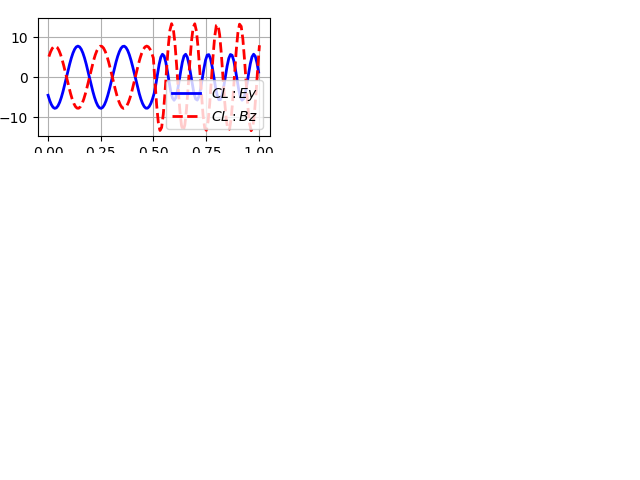

In [11]:
# ----------------------------------------------------------------------------------
# --- CLASSICAL: Plot variables in space ---
# ----------------------------------------------------------------------------------
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(
    vv_cl["xe"], np.real(Ey_cl), 
    color='b',  
    linewidth = 2, linestyle='-', 
    label = "$CL: Ey$"
)
ax.plot(
    vv_cl["xb"], np.real(Bz_cl), 
    color='r',  
    linewidth = 2, linestyle='--', 
    label = "$CL: Bz$"
)
plt.xlabel('$x$')
plt.ylabel("norm-Re[fields]")
ax.legend()
plt.grid(True)
plt.show()

Reading the file ../QuCF/simulations/matrix-inversion-EM//EM_kappa600_OUTPUT.hdf5...
Name of the simulation is EM
Simulation has been performed  01-24-2024 16:35:16

Reading the file ../QuCF/simulations/matrix-inversion-EM//EM_kappa700_OUTPUT.hdf5...
Name of the simulation is EM
Simulation has been performed  01-24-2024 16:19:41

Reading the file ../QuCF/simulations/matrix-inversion-EM//EM_kappa800_OUTPUT.hdf5...
Name of the simulation is EM
Simulation has been performed  01-24-2024 16:33:01

Reading the file ../QuCF/simulations/matrix-inversion-EM//EM_kappa1600_OUTPUT.hdf5...
Name of the simulation is EM
Simulation has been performed  01-24-2024 16:40:27

Reading the file ../QuCF/simulations/matrix-inversion-EM//EM_kappa2000_OUTPUT.hdf5...
Name of the simulation is EM
Simulation has been performed  01-24-2024 16:45:02

kappa, max. abs. error: 600.0, 7.615e-01
kappa, max. abs. error: 700.0, 3.272e-01
kappa, max. abs. error: 800.0, 1.241e-01
kappa, max. abs. error: 1600.0, 5.985e-04
kap

<IPython.core.display.Javascript object>


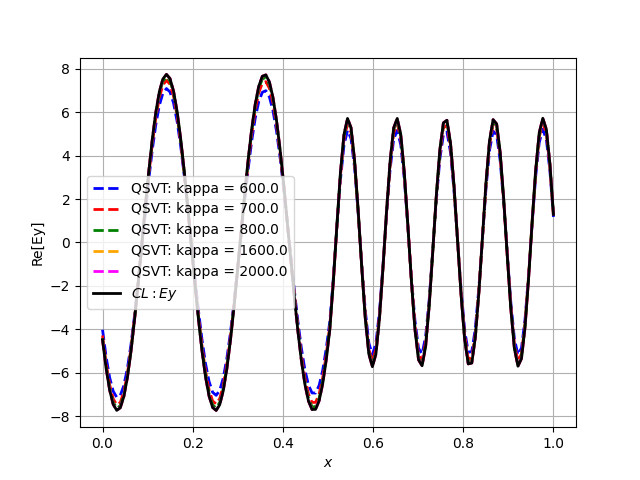

In [13]:
# ----------------------------------------------------------------------------------
# --- QC convergence: KAPPA ---
# ----------------------------------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(mse)

def read_qsvt_data(ii):
    oor_curr = mse.MeasOracle__();
    oor_curr.pname_ = "EM_kappa{:d}".format(kappa_qc_array[ii])
    oor_curr.path_  = path_root_
    oor_curr.open()
    oor_curr.read_qsvt()
    oor_curr.set_zero_ancillae_work_states(id_input_state = 0)
    
    kappa1 = oor_curr.dd_["MI"]["par"]
    rescaling_factor = oor_curr.dd_["MI"]["rescaling_factor"]
    
    # --- x-grid ---
    x_e_qc_curr = oor_curr.get_x_grid("j")
    shift_x = (x_e_qc_curr[1] - x_e_qc_curr[0])/2.
    x_b_qc_curr = shift_x + x_e_qc_curr

    # --- E, B fields ---
    Ey_qc_curr = oor_curr.get_var_x({"d": 0}, "j")
    Bz_qc_curr = oor_curr.get_var_x({"d": 1}, "j")
    
    # --- renormalize the fields ---
    coef_norm = 1./(rescaling_factor*kappa1)
    Ey_qc_curr = Ey_qc_curr/coef_norm
    Bz_qc_curr = Bz_qc_curr/coef_norm
    
    # --- save the fields ---
    oor_array.append(oor_curr)
    x_e_qc_array.append(x_e_qc_curr)
    x_b_qc_array.append(x_b_qc_curr)
    Ey_qc_array.append(Ey_qc_curr)
    Bz_qc_array.append(Bz_qc_curr)
    print()
    return
# ------------------------------------------------------------------------------



flag_real = True

colors = ["b", "r", "g", "orange", "magenta"]
oor_array = []
x_e_qc_array = []
x_b_qc_array = []
Ey_qc_array = []
Bz_qc_array = []

for ii in range(len(kappa_qc_array)):
    read_qsvt_data(ii)
    
# --- correct the global factor ---
if flag_real:
    y_work_qc = -np.imag(Ey_qc_array)
    y_work_cl = np.real(Ey_cl)
else:
    y_work_qc = -np.real(Ey_qc_array)
    y_work_cl = np.imag(Ey_cl)
    
# --- Compute the maximum abs. error ---
for ii in range(len(kappa_qc_array)):
    max_abs_err = np.max(np.abs(y_work_qc[ii] - y_work_cl))
    print("kappa, max. abs. error: {:0.1f}, {:0.3e}".format(
        oor_array[ii].dd_["MI"]["par"],
        max_abs_err)
    )

# --- Plotting ---
fig = plt.figure()
ax = fig.add_subplot(111)
for ii in range(len(kappa_qc_array)):   
    ax.plot(
        x_e_qc_array[ii], y_work_qc[ii], 
        color=colors[ii],  
        linewidth = 2, linestyle='--', 
        label = "QSVT: kappa = {:0.1f}".format(oor_array[ii].dd_["MI"]["par"])
    )
ax.plot(
    vv_cl["xe"], y_work_cl, 
    color='black',  
    linewidth = 2, linestyle='-', 
    label = "$CL: Ey$"
)

plt.xlabel('$x$')
if flag_real:
    plt.ylabel("Re[Ey]")
else:
    plt.ylabel("Im[Ey]")
ax.legend()
plt.grid(True)
plt.show()

del y_work_qc, y_work_cl, flag_real

In [ ]:
# --------------------------------------------------------
# --- Save the convergence on KAPPA ---
# --------------------------------------------------------
mix.reload_module(mix)

path_results = "./waves_dielectrics/stationary/figs"

flag_real = True

if flag_real:
    line_signal = "real"
    y_work_qc = -np.imag(Ey_qc_array)
    y_work_cl = np.real(Ey_cl)
else:
    line_signal = "imag"
    y_work_qc = -np.real(Ey_qc_array)
    y_work_cl = np.imag(Ey_cl)


for ii in range(len(kappa_qc_array)):
    mix.save_dat_plot_1d_file(
        path_results + "/conv_k{:d}_k{:d}_Ey_{:s}.dat".format(
            int(dd_work["kx"]), kappa_qc_array[ii], line_signal
        ), 
        x_b_qc_array[ii], 
        y_work_qc[ii]
    )
mix.save_dat_plot_1d_file(
    path_results + "/classical_k{:d}_Ey_{:s}.dat".format(int(dd_work["kx"]),line_signal), 
    vv_cl["xb"], 
    y_work_cl
)

del y_work_qc, y_work_cl, flag_real

In [6]:
# ------------------------------------------------------
# --- Find the condition number of the source matrix ---
# ------------------------------------------------------
_, s, _ = np.linalg.svd(A)
kappa = np.max(np.abs(s)) / np.min(np.abs(s[np.nonzero(s)]))
kappa_est = np.max(np.max(np.abs(A))) / np.min(np.min(np.abs(A[np.nonzero(A)])))
print("nx, Nx: {:d}, {:d}".format(dd_work["nqx"], dd_work["Nx"]))
print("condition number as |sing_max|/|sing_min|: \t{:0.3f}".format(kappa))
print("condition number as |A_max|/|A_min|: \t{:0.3f}".format(kappa_est))
del s, kappa, kappa_est

nx, Nx: 7, 128
condition number as |sing_max|/|sing_min|: 	407.496
condition number as |A_max|/|A_min|: 	8.876


In [15]:
# --- Draw the normalized matrix ---
mix.reload_module(mix)
mix.reload_module(sim)

dd_norm = sim.init(nqx = 2, nq_layers = 1, epss = [1,4], r0 = 4, kx = 7.2)
A_norm, b_norm  = sim.form_matrix(dd_norm, flag_norm = True)

# Print elements of the normalized matrix:
print("\n ---------------------------------")
sim.print_get_norm_h_element_EB(dd_norm)

# Print one block from the matrix:
if dd_norm["nqx"] < 4:
    print("\n\n")
    sim.print_matrix_block(dd_norm, A_norm, 1, 1)

# Print check whether the matrix is properly normalized:
print("\nif norm-A is <= 1?")
sim.print_max_row_norm(dd_norm, A_norm)

del dd_norm, A_norm, b_norm

Modeling: Nx = 4

 ---------------------------------
N-layers: 2
Nx in one layer: 2
max. value for norm: 4.000e+00
norm value: 1.600e+01
coef-superposition: 2

w: 	6.250e-02
0-th layer: w * eps: 	6.250e-02
1-th layer: w * eps: 	2.500e-01
1/(2h): 	6.510e-03
w*j + 1/h: 	1.302e-02+6.250e-02j
w*j - 1/h: 	-1.302e-02+6.250e-02j



--- Block(1, 1) ---

--- 0 ---
0.000e+00+6.250e-02j 0.000e+00+0.000e+00j 0.000e+00+0.000e+00j 0.000e+00+0.000e+00j
--- 1 ---
0.000e+00+0.000e+00j 0.000e+00+6.250e-02j 0.000e+00+0.000e+00j 0.000e+00+0.000e+00j
--- 2 ---
0.000e+00+0.000e+00j 0.000e+00+0.000e+00j 0.000e+00+6.250e-02j 0.000e+00+0.000e+00j
--- 3 ---
0.000e+00+0.000e+00j 0.000e+00+0.000e+00j -1.302e-02+6.250e-02j 1.302e-02+6.250e-02j

if norm-A is <= 1?
max-row-norm: 2.502e-01


In [5]:
# --- Print factors of the O_F oracle ---
dh = dd_work["coef-superposition"]

print("1/dh^3/2: {:0.3f}".format(1./(dh*np.sqrt(dh))))
print("1/dh^2:   {:0.3f}".format(1./(dh**2)))
print("1/dh:     {:0.3f}".format(1./(dh)))

del dh

1/dh^3/2: 0.354
1/dh^2:   0.250
1/dh:     0.500


In [5]:
# --- Print angles for the oracle ---
mix.reload_module(mix)
mix.reload_module(sim)

d_H = dd_work["coef-superposition"] 
N_layers = dd_work["N-layers"]

print()
w, w_epss, i2h, wph, wmh = sim.print_get_norm_h_element_EB(dd_work)

print("\n--- Resulting angles ---")

# i*w and i*w*eps (minus because of the Rx gate):
r_w = 2*np.arcsin(- w * d_H)

r_weps = np.zeros(N_layers)
for ii in range(N_layers):
    r_weps[ii] = 2*np.arcsin(- w_epss[ii] * d_H)

# i*w*epss[0] near the left edge (minus because of the Rx gate):
r_weps_el = 2*np.arcsin(- w_epss[0] * d_H*np.sqrt(d_H))

# i*w near the right edge (minus because of the Rx gate):
r_w_er = 2*np.arcsin(- w * d_H*np.sqrt(d_H))

# 1/(2h) and - 1/(2h):
r_2h  = 2*np.arcsin(i2h * d_H**2)
r_m2h = 2*np.arcsin(-i2h * d_H**2)

# 1/(2h) and - 1/(2h) near the edge:
r_2he  = 2*np.arcsin(i2h * d_H*np.sqrt(d_H)) - r_2h
r_m2he = 2*np.arcsin(-i2h * d_H*np.sqrt(d_H)) - r_m2h

# i*w + 1/h:
r, a = cmath.polar(wph)
r_wph = 2*np.arcsin(r * d_H*np.sqrt(d_H))
a_wph = -2*a

# i*w - 1/h:
r, a = cmath.polar(wmh)
r_wmh = 2*np.arcsin(r * d_H**2)
a_wmh = -2*a

# to zero elements:
r_pi  = - r_2h
r_mpi = - r_m2h

print("nqx  \t{:d}".format(dd_work["nqx"]))
print("Nx_layer  \t{:d}".format(dd_work["Nx-layer"]))
print()
print("r_w  \t\t{:0.14e}".format(r_w))
for ii in range(N_layers):
    print("r_weps{:d}  \t{:0.14e}".format(ii, r_weps[ii]))
print("r_weps_el  \t{:0.14e}".format(r_weps_el))
print("r_w_er  \t{:0.14e}".format(r_w_er))
print()
print("r_2h  \t{:0.14e}".format(r_2h))
print("r_m2h  \t{:0.14e}".format(r_m2h))
print("r_2he \t{:0.14e}".format(r_2he))
print("r_m2he \t{:0.14e}".format(r_m2he))
print()
print("r_wph  \t{:0.14e}".format(r_wph))
print("a_wph  \t{:0.14e}".format(a_wph))
print()
print("r_wmh  \t{:0.14e}".format(r_wmh))
print("a_wmh  \t{:0.14e}".format(a_wmh))
print()
print("r_pi   \t{:0.14e}".format(r_pi))
print("r_mpi  \t{:0.14e}".format(r_mpi))

del r, a


N-layers: 2
Nx in one layer: 32
max. value for norm: 1.260e+01
norm value: 5.040e+01
coef-superposition: 2

w: 	1.984e-02
0-th layer: w * eps: 	1.984e-02
1-th layer: w * eps: 	1.984e-02
1/(2h): 	6.250e-02
w*j + 1/h: 	1.250e-01+1.984e-02j
w*j - 1/h: 	-1.250e-01+1.984e-02j

--- Resulting angles ---
nqx  	6
Nx_layer  	32

r_w  		-7.9385923556e-02
r_weps0  	-7.9385923556e-02
r_weps1  	-7.9385923556e-02
r_weps_el  	-1.1229816976e-01
r_w_er  	-1.1229816976e-01

r_2h  	5.0536051028e-01
r_m2h  	-5.0536051028e-01
r_2he 	-1.4993930859e-01
r_m2he 	1.4993930859e-01

r_wph  	7.3220643645e-01
a_wph  	-3.1483374545e-01

r_wmh  	1.0616839707e+00
a_wmh  	-5.9683515617e+00

r_pi   	-5.0536051028e-01
r_mpi  	5.0536051028e-01
